In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import geopandas as gp

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler

from PreProcessing import PreProcessingShapefiles

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#np.set_printoptions(threshold=sys.maxsize)

# Read neighborhoods shapefile

In [10]:
path = r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\raw\shapefiles\neighborhoods'
neighborhoods_shp = gp.read_file(path + '/mgpc_2019.shp')

In [11]:
pps = PreProcessingShapefiles()
rp_neighborhoods_shp = pps.reprojectShapefiles([neighborhoods_shp])
rp_neighborhoods_shp[0].crs

All shapefiles were successfully reprojected.


<Derived Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
nshp = rp_neighborhoods_shp[0]
key_nshp = nshp.copy()
key_nshp = key_nshp[['CVEUT', 'geometry']]
key_nshp.columns = ['key_n', 'geometry']
key_nshp['key_n'] = key_nshp['key_n'].astype('string')
key_nshp.head()

,key_n,geometry
0,02-001,"POLYGON ((483311.618 2153254.848, 483332.006 2..."
1,02-002,"POLYGON ((484406.956 2153012.331, 484401.132 2..."
2,02-005,"POLYGON ((480013.755 2153003.618, 480026.649 2..."
3,02-006,"POLYGON ((484061.118 2152622.284, 484061.678 2..."
4,02-007,"POLYGON ((480104.707 2154525.214, 480118.178 2..."


In [13]:
key_nshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   key_n     1815 non-null   string  
 1   geometry  1815 non-null   geometry
dtypes: geometry(1), string(1)
memory usage: 28.5 KB


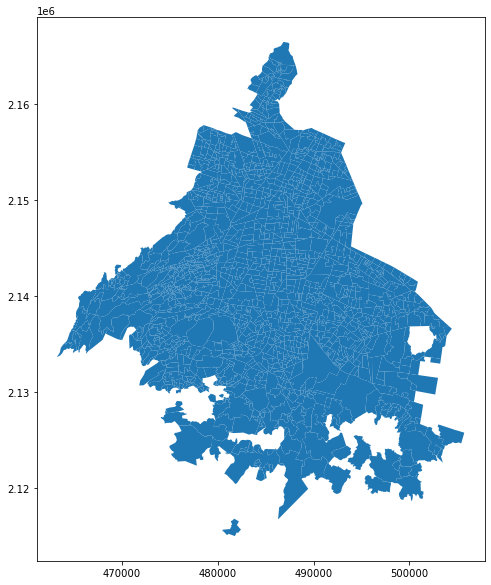

In [14]:
key_nshp.plot(figsize=(10,10))
plt.show()

# Read dataset

In [15]:
# Read dataset
df = pd.read_csv(r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\preprocessed\data_hotspots_forecasting_final.csv')
df.set_index('unique_id', inplace=True)
df["unique_id_time"] = pd.to_datetime(df["unique_id_time"])
print("Rows: ", df.shape[0])
print("Features: " + str(df.shape[1]) + "\n")
df.head(10)

Rows:  63525
Features: 41



,key_neighb,unique_id_time,crime_count_t,crime_count_t+1,women_vic_t,women_vic_t+1,men_vic_t,men_vic_t+1,less_18_vic_t,less_18_vic_t+1,18_to_29_vic_t,18_to_29_vic_t+1,30_to_39_vic_t,30_to_39_vic_t+1,40_to_49_vic_t,40_to_49_vic_t+1,50_to_59_vic_t,50_to_59_vic_t+1,more_60_vic_t,more_60_vic_t+1,cablebus_s,commer_ven,health_cen,metro_sta,pmarkets,pparking,hospitals,train_sta,trolebus_s,cablebus_l,ptransp_ro,main_roads,metro_line,rtp_lines,train_line,trolebus_l,centres_va,be_schools,commercial,industrial,service_un
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019202-001,02-001,2019-02-01,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019302-001,02-001,2019-03-01,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019402-001,02-001,2019-04-01,0.0,1,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019502-001,02-001,2019-05-01,1.0,1,0.0,0,1.0,2,0.0,1,1.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019602-001,02-001,2019-06-01,1.0,0,0.0,0,2.0,0,1.0,0,0.0,0,1.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019702-001,02-001,2019-07-01,0.0,1,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019802-001,02-001,2019-08-01,1.0,0,0.0,0,1.0,0,0.0,0,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019902-001,02-001,2019-09-01,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
20191002-001,02-001,2019-10-01,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43


In [16]:
clusters = pd.read_csv(r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\preprocessed\clusters_jnb.csv')
clusters.columns = ['key_neighb', 'geometry', 'crime_count', 'class']
geometries = clusters[['key_neighb', 'geometry']]
clusters.drop(['geometry', 'crime_count'], axis=1, inplace=True)
print(clusters.shape)
clusters.head(3)


(1815, 2)


,key_neighb,class
0,02-001,1
1,02-002,1
2,02-005,1


In [17]:
pivot_df = pd.pivot_table(df, index='key_neighb', values = ['crime_count_t+1', 'crime_count_t', 'women_vic_t+1', 'men_vic_t+1', 
                                                           'less_18_vic_t+1', '18_to_29_vic_t+1', '30_to_39_vic_t+1', 
                                                            '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'more_60_vic_t+1',
                                                           'cablebus_s', 'commer_ven', 'health_cen', 'metro_sta', 'pmarkets', 
                                                            'pparking', 'hospitals', 'train_sta', 'trolebus_s', 'cablebus_l', 
                                                            'ptransp_ro', 'main_roads', 'metro_line', 'rtp_lines', 'train_line', 
                                                            'trolebus_l', 'centres_va', 'be_schools', 'commercial', 'industrial', 
                                                            'service_un'], aggfunc=np.median).reset_index()
print(pivot_df.shape)
pivot_df.head()


(1815, 32)


,key_neighb,18_to_29_vic_t+1,30_to_39_vic_t+1,40_to_49_vic_t+1,50_to_59_vic_t+1,be_schools,cablebus_l,cablebus_s,centres_va,commer_ven,commercial,crime_count_t,crime_count_t+1,health_cen,hospitals,industrial,less_18_vic_t+1,main_roads,men_vic_t+1,metro_line,metro_sta,more_60_vic_t+1,pmarkets,pparking,ptransp_ro,rtp_lines,service_un,train_line,train_sta,trolebus_l,trolebus_s,women_vic_t+1
0,02-001,0,0,0,0,1,0,0,0,0,63,1.0,1,0,0,10,0,1,0,0,0,0,0,0,9,6,43,0,0,1,2,0
1,02-002,0,0,0,0,2,0,0,0,0,52,1.0,1,0,0,13,0,1,1,0,0,0,0,0,2,4,56,0,0,1,0,0
2,02-003,0,0,0,0,0,0,0,0,0,20,1.0,1,0,0,4,0,1,0,0,0,0,0,0,8,1,18,0,0,0,0,0
3,02-005,0,0,0,0,3,0,0,0,0,53,2.0,2,0,0,10,1,0,2,1,1,0,0,2,30,6,89,0,0,0,0,0
4,02-006,0,0,0,0,4,0,0,0,0,164,2.0,2,0,1,22,0,0,1,0,0,0,1,0,6,3,88,0,0,0,0,0


In [18]:
merged_df = pivot_df.merge(clusters, on='key_neighb', how='left').set_index('key_neighb')
merged_df.head(3)

,18_to_29_vic_t+1,30_to_39_vic_t+1,40_to_49_vic_t+1,50_to_59_vic_t+1,be_schools,cablebus_l,cablebus_s,centres_va,commer_ven,commercial,crime_count_t,crime_count_t+1,health_cen,hospitals,industrial,less_18_vic_t+1,main_roads,men_vic_t+1,metro_line,metro_sta,more_60_vic_t+1,pmarkets,pparking,ptransp_ro,rtp_lines,service_un,train_line,train_sta,trolebus_l,trolebus_s,women_vic_t+1,class
key_neighb,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02-001,0,0,0,0,1,0,0,0,0,63,1.0,1,0,0,10,0,1,0,0,0,0,0,0,9,6,43,0,0,1,2,0,1
02-002,0,0,0,0,2,0,0,0,0,52,1.0,1,0,0,13,0,1,1,0,0,0,0,0,2,4,56,0,0,1,0,0,1
02-003,0,0,0,0,0,0,0,0,0,20,1.0,1,0,0,4,0,1,0,0,0,0,0,0,8,1,18,0,0,0,0,0,1


In [19]:
merged_df.columns

Index(['18_to_29_vic_t+1', '30_to_39_vic_t+1', '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'be_schools', 'cablebus_l', 'cablebus_s', 'centres_va', 'commer_ven', 'commercial', 'crime_count_t', 'crime_count_t+1', 'health_cen', 'hospitals', 'industrial', 'less_18_vic_t+1', 'main_roads', 'men_vic_t+1', 'metro_line', 'metro_sta', 'more_60_vic_t+1', 'pmarkets', 'pparking', 'ptransp_ro', 'rtp_lines', 'service_un', 'train_line', 'train_sta', 'trolebus_l', 'trolebus_s', 'women_vic_t+1', 'class'], dtype='object')

## Descriptive analysis

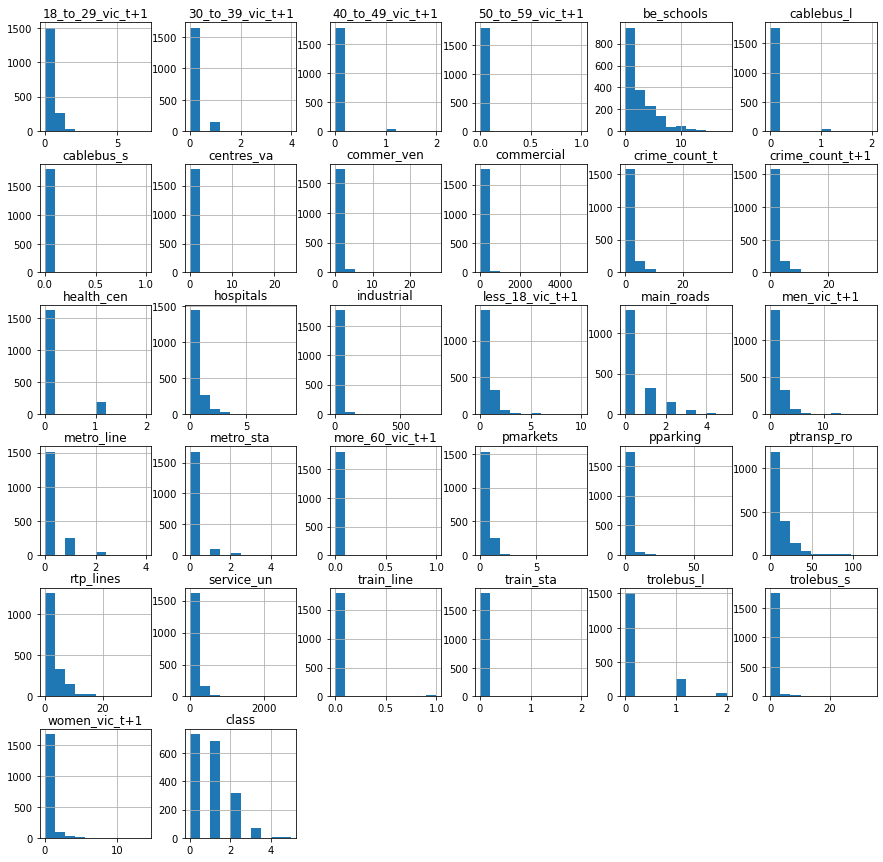

In [20]:
merged_df.hist(figsize=(15,15))
plt.show()

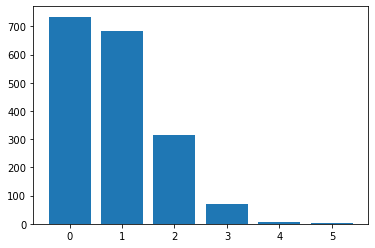

In [21]:
classes = merged_df[['class']].value_counts().rename_axis('class').reset_index(name = 'count')
plt.bar(classes['class'], classes['count'])
plt.show()

## Train-test splits

In [90]:
# Attributes that will classify
X_cols = ['18_to_29_vic_t+1', '30_to_39_vic_t+1', '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'be_schools', 'cablebus_l', 'cablebus_s', 'centres_va', 'commer_ven', 'commercial', 'health_cen', 'hospitals', 'industrial', 'less_18_vic_t+1', 'main_roads', 'men_vic_t+1', 'metro_line', 'metro_sta', 'more_60_vic_t+1', 'pmarkets', 'pparking', 'ptransp_ro', 'rtp_lines', 'service_un', 'train_line', 'train_sta', 'trolebus_l', 'trolebus_s', 'women_vic_t+1']
X = merged_df[['18_to_29_vic_t+1', '30_to_39_vic_t+1', '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'be_schools', 'cablebus_l', 'cablebus_s', 'centres_va', 'commer_ven', 'commercial', 'health_cen', 'hospitals', 'industrial', 'less_18_vic_t+1', 'main_roads', 'men_vic_t+1', 'metro_line', 'metro_sta', 'more_60_vic_t+1', 'pmarkets', 'pparking', 'ptransp_ro', 'rtp_lines', 'service_un', 'train_line', 'train_sta', 'trolebus_l', 'trolebus_s', 'women_vic_t+1']].values

#Target variable - labels
y_col = ['class']
y = merged_df[['class']].values


In [33]:
"""# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='not majority')"""

In [38]:
"""# summarize output class distribution
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)"""

[[  0 734]
 [  1 685]
 [  2 315]
 [  3  71]
 [  4   7]
 [  5   3]]


In [40]:
"""# fit and apply the transform
X_os, y_os = oversample.fit_resample(X, y)"""

In [41]:
"""# summarize output class distribution after random oversampling
(unique, counts) = np.unique(y_os, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)"""

[[  0 734]
 [  1 734]
 [  2 734]
 [  3 734]
 [  4 734]
 [  5 734]]


In [44]:
"""# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)"""

(3082, 29) (3082,)
(1322, 29) (1322,)


In [92]:
# Split the dataset into train and test sets

oversample = RandomOverSampler(sampling_strategy='not majority')
X_os, y_os = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.3, random_state=42)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
ten_strat_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


## Zero Rule algorithm

In [171]:
# Define pipeline and GridCV for multinominal logistic regression

zra_steps = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), 
             ('zra', DummyClassifier(random_state = 42))]
zra_pipeline = Pipeline(zra_steps)
zra_parameters = {'zra__strategy':['most_frequent']}

list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    zra_grid = GridSearchCV(zra_pipeline, param_grid=zra_parameters, cv=ten_strat_fold, scoring=score)

    zra_grid.fit(X_train, y_train)

    print(score + " score = %3.2f" %(zra_grid.score(X_test, y_test)))
    print('\n')
    

balanced_accuracy score = 0.17




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

precision_weighted score = 0.02


f1_weighted score = 0.04




In [172]:
# Define pipeline and GridCV for multinominal logistic regression

zra_steps = [('zra', DummyClassifier(random_state = 42))]
zra_pipeline = Pipeline(zra_steps)
zra_parameters = {'zra__strategy':['most_frequent']}

list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    zra_grid = GridSearchCV(zra_pipeline, param_grid=zra_parameters, cv=ten_strat_fold, scoring=score)

    zra_grid.fit(X_train, y_train)

    print(score + " score = %3.2f" %(zra_grid.score(X_test, y_test)))
    print('\n')
    

balanced_accuracy score = 0.17


precision_weighted score = 0.02


f1_weighted score = 0.04




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

## Multinominal Logistic Regression

In [104]:
# Define pipeline and GridCV for multinominal logistic regression

mlr_steps = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), 
             ('mlr', LogisticRegression(multi_class = 'multinomial', random_state = 42, max_iter = 1000))]
mlr_pipeline = Pipeline(mlr_steps)

mlr_parameters = {'mlr__solver':['lbfgs', 'newton-cg']}
list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    mlr_grid = GridSearchCV(mlr_pipeline, param_grid=mlr_parameters, cv=ten_strat_fold, scoring=score)

    mlr_grid.fit(X_train, y_train)

    print(mlr_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(mlr_grid.score(X_test,y_test)))
    print('\n')



{'mlr__solver': 'lbfgs'} 

balanced_accuracy score = 0.93



{'mlr__solver': 'lbfgs'} 

precision_weighted score = 0.93



{'mlr__solver': 'lbfgs'} 

f1_weighted score = 0.92





In [109]:
# Define pipeline and GridCV for multinominal logistic regression, no pre-processing

mlr_steps_np = [('mlr', LogisticRegression(multi_class = 'multinomial', random_state = 42, max_iter = 5000))]
mlr_pipeline_np = Pipeline(mlr_steps_np)

for score in list_scoring:
    mlr_grid = GridSearchCV(mlr_pipeline_np, param_grid=mlr_parameters, cv=ten_strat_fold, scoring=score)

    mlr_grid.fit(X_train, y_train)

    print(mlr_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(mlr_grid.score(X_test,y_test)))
    print('\n')

# The results indicate that without rescaling the inputs, the solver cannot converge as the number of iterations reaches its limit


C:\Users\penny\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

KeyboardInterrupt: 

## Naive Bayes

In [113]:
# Define pipeline and GridCV for multinominal logistic regression

nb_steps = [('normalizer', MinMaxScaler()), ('nb', CategoricalNB())]
nb_pipeline = Pipeline(nb_steps)

nb_parameters = {'nb__alpha':[0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.5, 1]}
list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    nb_grid = GridSearchCV(nb_pipeline, param_grid=nb_parameters, cv=ten_strat_fold, scoring=score)

    nb_grid.fit(X_train, y_train)

    print(nb_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(nb_grid.score(X_test,y_test)))
    print('\n')

# The results indicate that NB cannot function with negative inputs, which results from applying the power transform

{'nb__alpha': 0.001} 

balanced_accuracy score = 0.44




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

{'nb__alpha': 0.001} 

precision_weighted score = 0.62


{'nb__alpha': 0.001} 

f1_weighted score = 0.39




In [173]:
# Define pipeline and GridCV for multinominal logistic regression, no pre-processing

nb_steps_np = [('nb', CategoricalNB())]
nb_pipeline_np = Pipeline(nb_steps_np)

for score in list_scoring:
    nb_grid = GridSearchCV(nb_pipeline, param_grid=nb_parameters, cv=ten_strat_fold, scoring=score)

    nb_grid.fit(X_train, y_train)

    print(nb_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(nb_grid.score(X_test,y_test)))
    print('\n')

{'nb__alpha': 0.001} 

balanced_accuracy score = 0.44




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

{'nb__alpha': 0.001} 

precision_weighted score = 0.62


{'nb__alpha': 0.001} 

f1_weighted score = 0.39




## Decision Tree

In [114]:
# Define pipeline and GridCV for multinominal logistic regression

dt_steps = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), ('dt', DecisionTreeClassifier(random_state=42))]
dt_pipeline = Pipeline(dt_steps)

dt_parameters = {'dt__criterion': ['gini', 'entropy'], 'dt__max_depth': np.arange(3, 15)}
list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    dt_grid = GridSearchCV(dt_pipeline, param_grid=dt_parameters, cv=ten_strat_fold, scoring=score)

    dt_grid.fit(X_train, y_train)

    print(dt_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(dt_grid.score(X_test,y_test)))
    print('\n')

{'dt__criterion': 'entropy', 'dt__max_depth': 9} 

balanced_accuracy score = 0.94




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

{'dt__criterion': 'entropy', 'dt__max_depth': 12} 

precision_weighted score = 0.94


{'dt__criterion': 'entropy', 'dt__max_depth': 9} 

f1_weighted score = 0.94




In [115]:
# Define pipeline and GridCV for multinominal logistic regression, no pre-processing

dt_steps_np = [('dt', DecisionTreeClassifier(random_state=42))]
dt_pipeline_np = Pipeline(dt_steps_np)

for score in list_scoring:
    dt_grid = GridSearchCV(dt_pipeline, param_grid=dt_parameters, cv=ten_strat_fold, scoring=score)

    dt_grid.fit(X_train, y_train)

    print(dt_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(dt_grid.score(X_test,y_test)))
    print('\n')

{'dt__criterion': 'entropy', 'dt__max_depth': 12} 

balanced_accuracy score = 0.94




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedM

{'dt__criterion': 'entropy', 'dt__max_depth': 12} 

precision_weighted score = 0.94


{'dt__criterion': 'entropy', 'dt__max_depth': 12} 

f1_weighted score = 0.94




## Random Forest

In [117]:
# Define pipeline and GridCV for multinominal logistic regression

rf_steps = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), ('rf', RandomForestClassifier(random_state=42))]
rf_pipeline = Pipeline(rf_steps)

rf_parameters = {'rf__criterion': ['gini', 'entropy'], 'rf__max_depth': np.arange(3, 15)}
list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_parameters, cv=ten_strat_fold, scoring=score)

    rf_grid.fit(X_train, y_train)

    print(rf_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(rf_grid.score(X_test,y_test)))
    print('\n')




{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

balanced_accuracy score = 0.96


{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

precision_weighted score = 0.96


{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

f1_weighted score = 0.96




In [133]:
# Define pipeline and GridCV for multinominal logistic regression

rf_steps_np = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), ('rf', RandomForestClassifier(random_state=42))]
rf_pipeline_np = Pipeline(rf_steps_np)

for score in list_scoring:
    rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_parameters, cv=ten_strat_fold, scoring=score)

    rf_grid.fit(X_train, y_train)

    print(rf_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(rf_grid.score(X_test,y_test)))
    print('\n')

{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

balanced_accuracy score = 0.96


{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

precision_weighted score = 0.96


{'rf__criterion': 'entropy', 'rf__max_depth': 14} 

f1_weighted score = 0.96




Accuracy: 95.61
Precision: 95.75412538867255

[[('men_vic_t+1', 0.21), ('less_18_vic_t+1', 0.12), ('women_vic_t+1', 0.11), ('service_un', 0.08), ('18_to_29_vic_t+1', 0.07), ('pparking', 0.07), ('commercial', 0.06), ('30_to_39_vic_t+1', 0.05), ('industrial', 0.04), ('metro_sta', 0.04), ('40_to_49_vic_t+1', 0.03), ('centres_va', 0.02), ('commer_ven', 0.02), ('ptransp_ro', 0.02), ('be_schools', 0.01), ('main_roads', 0.01), ('metro_line', 0.01), ('rtp_lines', 0.01), ('trolebus_l', 0.01), ('trolebus_s', 0.01), ('50_to_59_vic_t+1', 0.0), ('cablebus_l', 0.0), ('cablebus_s', 0.0), ('health_cen', 0.0), ('hospitals', 0.0), ('more_60_vic_t+1', 0.0), ('pmarkets', 0.0), ('train_line', 0.0), ('train_sta', 0.0)]]



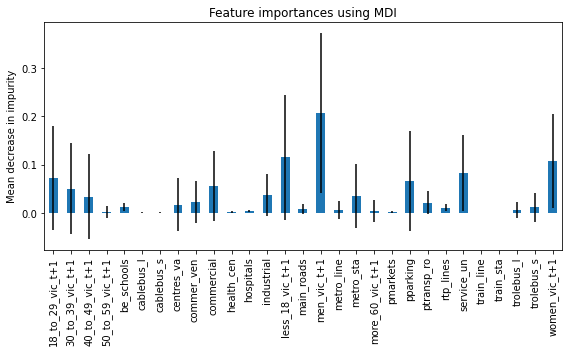

In [132]:
# Create Decision Tree classifer object
rf_fi = RandomForestClassifier(criterion = 'entropy', max_depth = 14, random_state=42)
rf_fi = rf_fi.fit(X_train, y_train)
y_pred_rf_fi = rf_fi.predict(X_test)

print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred_rf_fi) * 100))
print("Precision:", np.mean(precision_score(y_test, y_pred_rf_fi, average=None))*100)
print()

importances_list = []
importances = list(rf_fi.feature_importances_) # Get numerical feature importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_cols, importances)] # List of tuples with variable and importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # Sort the feature importances by most important first
importances_list.append(feature_importances)
print(importances_list)
print()

forest_importances = pd.Series(importances, index=X_cols)
std = np.std([tree.feature_importances_ for tree in rf_fi.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Multi-Layer Perceptron

In [136]:
# Define pipeline and GridCV for multinominal logistic regression

mlp_steps = [('normalizer', MinMaxScaler()), ('power_transform', PowerTransformer(method='yeo-johnson')), ('mlp', MLPClassifier(random_state=42, max_iter = 1000))]
mlp_pipeline = Pipeline(mlp_steps)

mlp_parameters = {'mlp__hidden_layer_sizes': [(18,), (18,18)], 'mlp__activation': ['tanh', 'relu'], 'mlp__solver': ['sgd', 'adam'], 
                  'mlp__alpha': [0.0001, 0.05], 'mlp__learning_rate': ['constant','adaptive']}
list_scoring = ['balanced_accuracy', 'precision_weighted', 'f1_weighted']

for score in list_scoring:
    mlp_grid = GridSearchCV(mlp_pipeline, param_grid=mlp_parameters, cv=ten_strat_fold, scoring=score)

    mlp_grid.fit(X_train, y_train)

    print(mlp_grid.best_params_, '\n')
    print(score + " score = %3.2f" %(mlp_grid.score(X_test,y_test)))
    print('\n')




C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_m

{'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (18, 18), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

balanced_accuracy score = 0.93




C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_m

{'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (18, 18), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

precision_weighted score = 0.93




C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_m

{'mlp__activation': 'tanh', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (18, 18), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

f1_weighted score = 0.93




In [174]:
# Define pipeline and GridCV for multinominal logistic regression, no pre-processing

mlp_steps_np = [('mlp', MLPClassifier(random_state=42, max_iter = 1000))]
mlp_pipeline_np = Pipeline(mlp_steps_np)

for score in list_scoring:
    mlp_grid_np = GridSearchCV(mlp_pipeline_np, param_grid=mlp_parameters, cv=ten_strat_fold, scoring=score)

    mlp_grid_np.fit(X_train, y_train)

    print(mlp_grid_np.best_params_, '\n')
    print(score + " score = %3.2f" %(mlp_grid_np.score(X_test,y_test)))
    print('\n')




C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_m

{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (18,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

balanced_accuracy score = 0.93




C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:70

{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (18,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

precision_weighted score = 0.92




C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_m

{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (18,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'} 

f1_weighted score = 0.92


